In [20]:
# Importing stuff

import torch

import numpy as np
import matplotlib.pyplot as plt

import csv

import plotly.graph_objects as go
import nbformat
import networkx as nx

import pandas as pd

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import visdcc

from random import seed
from random import random

import dash_cytoscape as cyto
from dash.dependencies import Input, Output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

print(torch.__version__)
print(torch.version.cuda)

# https://www.kaggle.com/elmahy/attentional-spatio-temporal-gcn
# https://github.com/rusty1s/pytorch_spline_conv
# https://arxiv.org/pdf/2112.03558v1.pdf
# https://github.com/jeongwhanchoi/STG-NCDE
# https://plotly.com/python/network-graphs/
# https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python
# https://stackoverflow.com/questions/45490002/how-to-use-dash-within-jupyter-notebook-or-jupyterlab
# https://github.com/jimmybow/visdcc
# https://pythonrepo.com/repo/imohitmayank-jaal
# https://arxiv.org/pdf/2106.09305.pdf

CUDA: True cuda:0
1.11.0+cu102
10.2


In [22]:
def show_dataset_information(filename, dataset):
    print("Data loaded from", filename, "!")
    print("Shape: ", dataset.shape)
    print("Values: min =", dataset.min(), 'max =', dataset.max(), 'mean =', dataset.mean(), 'median =', np.median(dataset))
import os
unknown_dir = os.system("which python3")
print("`cd doesnotexis` ran with exit code %d" % unknown_dir)

/mnt/venv/bin/python3
`cd doesnotexis` ran with exit code 0


In [23]:
def normalize(dataset):
    #min_x = dataset.min(axis=0)
    #max_x = dataset.max(axis=0)
    #min_y = dataset.min(axis=1)
    #max_y = dataset.max(axis=1)

    minn = dataset.min()
    maxx = dataset.max()

    final = []

    for row in dataset:
        build = []
        for value in row:
            value = (value - minn) / (maxx - minn)
            #if value <= 0.33:
            #    value = 0
            #else:
            #    value = 1
            build.append(value)
        final.append(build)

    return np.array(final)

In [91]:
# Loading the dataset

file_npz = 'data/PEMS04/PEMS04.npz'

loaded = np.load(file_npz)

loaded_data = loaded['data'][:, :, 0]

#loaded_data = np.expand_dims(loaded_data, axis=-1)

show_dataset_information(file_npz.split('/')[-1], loaded_data)
max_intersection_value = loaded_data.max()
loaded_data = normalize(loaded_data)
show_dataset_information(file_npz.split('/')[-1], loaded_data)

Data loaded from PEMS04.npz !
Shape:  (16992, 307)
Values: min = 0.0 max = 919.0 mean = 211.7007794815878 median = 180.0
Data loaded from PEMS04.npz !
Shape:  (16992, 307)
Values: min = 0.0 max = 1.0 mean = 0.23035993414753855 median = 0.19586507072905332


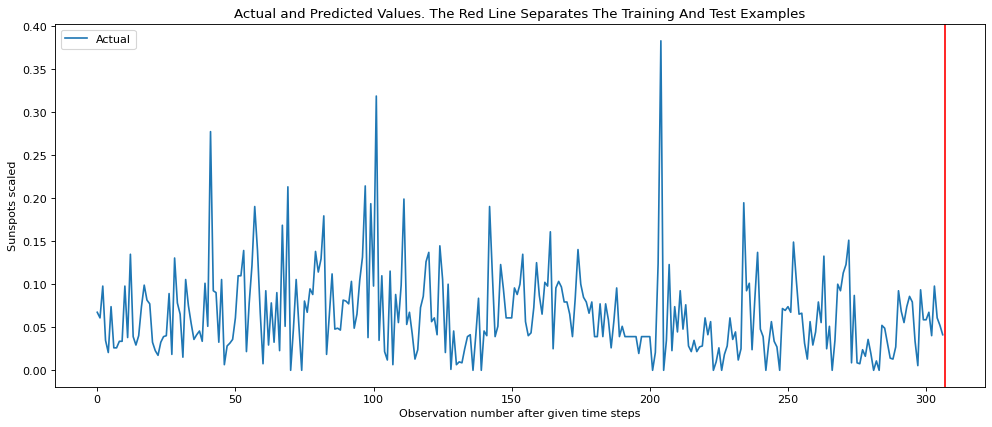

In [25]:
def plot_one(actual):
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.axvline(x=len(actual), color='r')
    plt.legend(['Actual'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_one(loaded_data[0][0:2500])

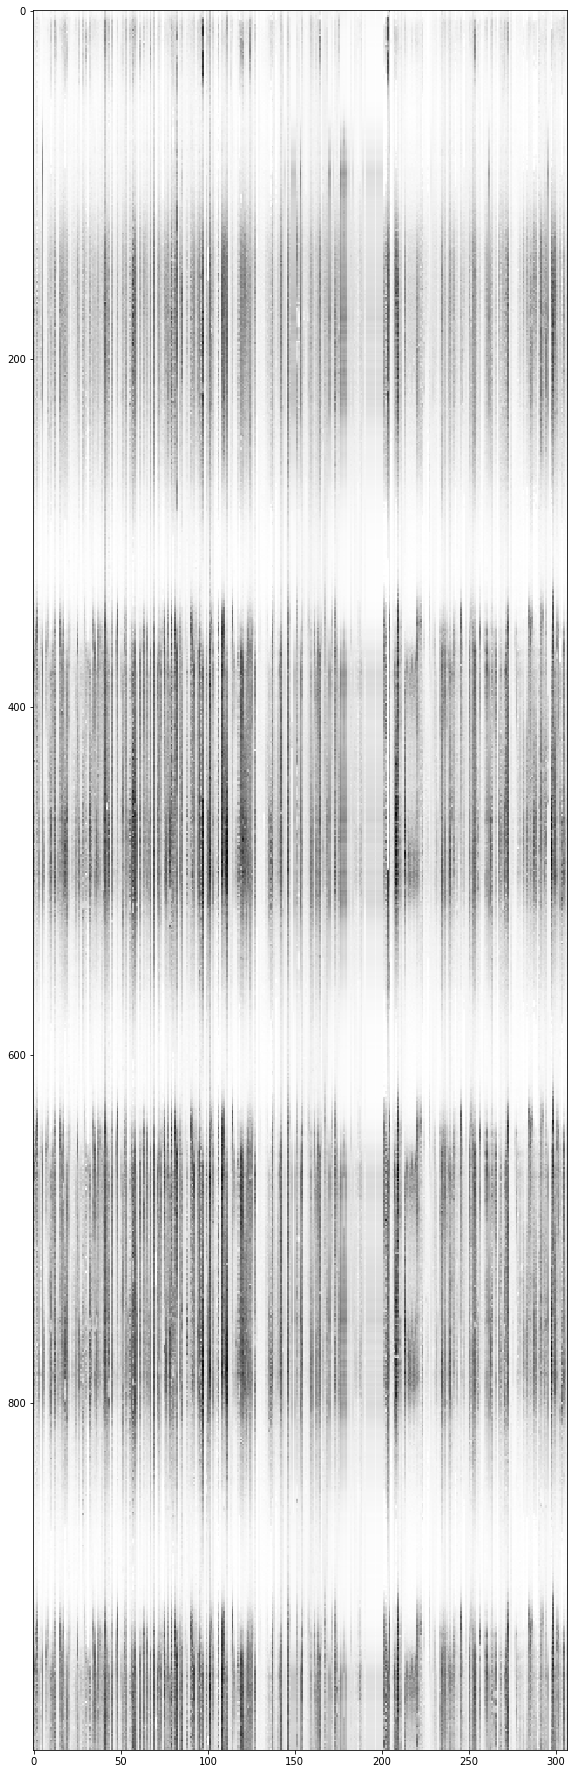

In [26]:
# Illustrating the dataset

fig = plt.figure(figsize=(60, 32))

plt.imshow(loaded_data[:1000,:], interpolation='none', cmap='Greys')
plt.show()

In [27]:
# Loading the graph connections

file_csv = 'data/PEMS04/PEMS04.csv'

G = nx.Graph()

G.add_nodes_from([i for i in range(307)])

with open(file_csv, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        splitted = row[0].split(',')
        if splitted[0] == 'from':
            continue
        G.add_edge(int(splitted[0]), int(splitted[1]), weight=float(splitted[2]))

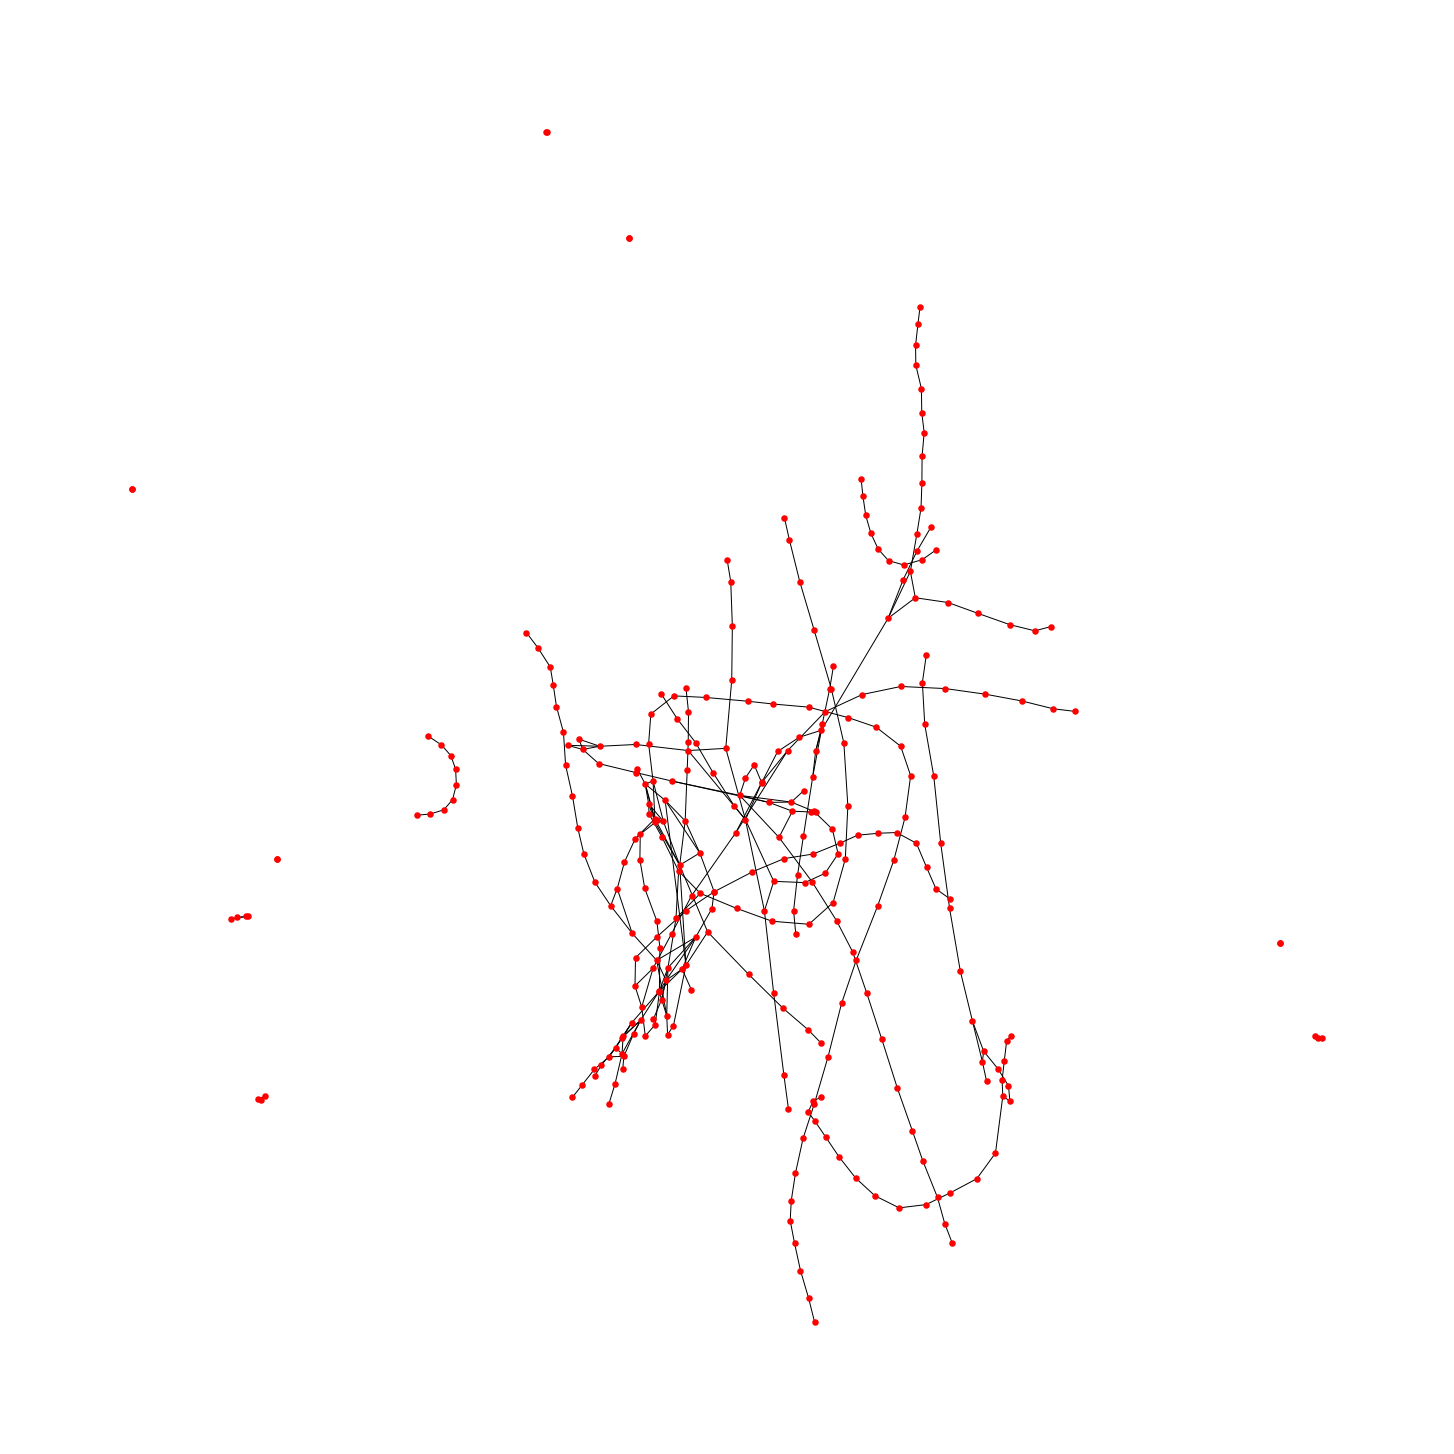

In [28]:
# Illustrating the graph connections

fig = plt.figure(figsize=(20, 20))

fixed_draw = nx.spring_layout(G, seed = 900)
nx.draw(G, pos = fixed_draw, with_labels=False, font_size=5, edge_color='black', linewidths=1.5, node_color='red', node_size=25)
plt.show()
# plt.savefig("save_graph.png")

In [ ]:
# Interacting traffic graph

nodes = [{'color': "#00FF00", 'id': i, 'label': i, 'shape': 'dot', 'size': 30} for i in range(307)]

edges = []

with open(file_csv, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        splitted = row[0].split(',')
        if splitted[0] == 'from':
            continue
        edges.append({'id': splitted[0] + " - " + splitted[1],
                      'from': splitted[0],
                      'to': splitted[1],
                      'weight': float(splitted[2])/100,
                      'edgeLength': float(splitted[2])/100})

app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Routes with traffic"),
    visdcc.Network(id = 'net',
                   data = {'nodes': nodes, 'edges': edges},
                   options = dict(height='600px', width='100%')),
    dcc.Interval(
        id='interval',
        interval=1*100,
        n_intervals=0
    ),
])

def calculate_hex(node, times_executed):
    toDupli = hex(int(255 - loaded_data[times_executed][node]*255))[2:4]
    return "#" + toDupli + toDupli + toDupli

@app.callback(Output('net', 'data'), [Input('interval', 'n_intervals')])
def update_data(times_executed):
    nodes = [{'color': calculate_hex(i, times_executed), 'id': i, 'label': i, 'shape': 'dot', 'size': 30} for i in range(307)]
    return {'nodes': nodes, 'edges': edges}

app.run_server(mode='inline', port = 8090, dev_tools_ui=True, #debug=True,
               dev_tools_hot_reload =True, threaded=True)

In [30]:
loaded_data = loaded_data.T

In [31]:
len(loaded_data)

307

In [58]:
split_percent = 0.8
split = [0 for i in range(len(loaded_data))]
train_data = [[] for i in range(len(loaded_data))]
test_data = [[] for i in range(len(loaded_data))]
#print(str(loaded_data[0][range(split)]))
for i in range(len(loaded_data)):
    split[i] = int(len(loaded_data[i])*split_percent)
    train_data[i] = loaded_data[i][range(split[i])]
    test_data[i] = loaded_data[i][split[i]:]

In [59]:
train_data

[array([0.06746464, 0.0663765 , 0.07725789, ..., 0.05331882, 0.07399347,
        0.07399347]),
 array([0.0609358 , 0.04352557, 0.0304679 , ..., 0.09249184, 0.08922742,
        0.085963  ]),
 array([0.09793254, 0.10228509, 0.085963  , ..., 0.11969532, 0.16539717,
        0.17301415]),
 array([0.03482046, 0.02720348, 0.03917301, ..., 0.01523395, 0.01849837,
        0.01741023]),
 array([0.02067465, 0.01741023, 0.00979325, ..., 0.02067465, 0.01305767,
        0.02393906]),
 array([0.07399347, 0.06964091, 0.06528836, ..., 0.13057671, 0.12948857,
        0.1523395 ]),
 array([0.02611534, 0.02393906, 0.02720348, ..., 0.0250272 , 0.01741023,
        0.0304679 ]),
 array([0.02611534, 0.00761697, 0.01196953, ..., 0.02829162, 0.02829162,
        0.03808487]),
 array([0.03373232, 0.03155604, 0.02720348, ..., 0.06528836, 0.05440696,
        0.06855277]),
 array([0.03373232, 0.0359086 , 0.05005441, ..., 0.02393906, 0.04461371,
        0.02937976]),
 array([0.09793254, 0.10881393, 0.06746464, ..., 0

In [34]:
def separate(data, steps):
    Y_chosen = np.arange(steps, len(data), steps)
    Y = data[Y_chosen]
    X = data[range(steps*len(Y))]
    X = np.reshape(X, (len(Y), steps, 1))
    return X, Y

In [61]:
steps = 12
trainX = []
trainY = []
testX = []
testY = []
for i in range(len(loaded_data)):
    trainXT, trainYT = separate(train_data[i], steps)
    testXT, testYT = separate(test_data[i], steps)
    trainX.append(trainXT)
    trainY.append(trainYT)
    testX.append(testXT)
    testY.append(testYT)

In [62]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18109723129854384874
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3205562368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15959606819525700479
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-03-20 09:50:14.663835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 09:50:14.664143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 09:50:14.664302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 09:50:14.664517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 09:50:14.664799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [67]:
model = keras.Sequential()

#model.add(layers.Embedding(input_dim=steps, output_dim=64))

model.add(layers.LSTM(128))

model.add(layers.Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

tf.config.run_functions_eagerly(True)

In [68]:
for i in range(len(trainX)):
    model.fit(trainX[i], trainY[i], epochs=1, batch_size=1, verbose=2)

/mnt/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1132/1132 - 14s - loss: 0.0376 - 14s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0290 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0488 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0178 - 13s/epoch - 12ms/step
1132/1132 - 14s - loss: 0.0166 - 14s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0175 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0212 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0149 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0181 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0185 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0392 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0188 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0466 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0142 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0142 - 13s/epoch - 12ms/step
1132/1132 - 14s - loss: 0.0250 - 14s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0236 - 13s/epoch - 12ms/step
1132/1132 - 13s - loss: 0.0243 - 13s/epoch - 12ms/step
1132/1132 

In [70]:
train_predict = []
test_predict = []
for i in range(len(trainX)):
    train_predict.append(model.predict(trainX[i]))
    test_predict.append(model.predict(testX[i]))

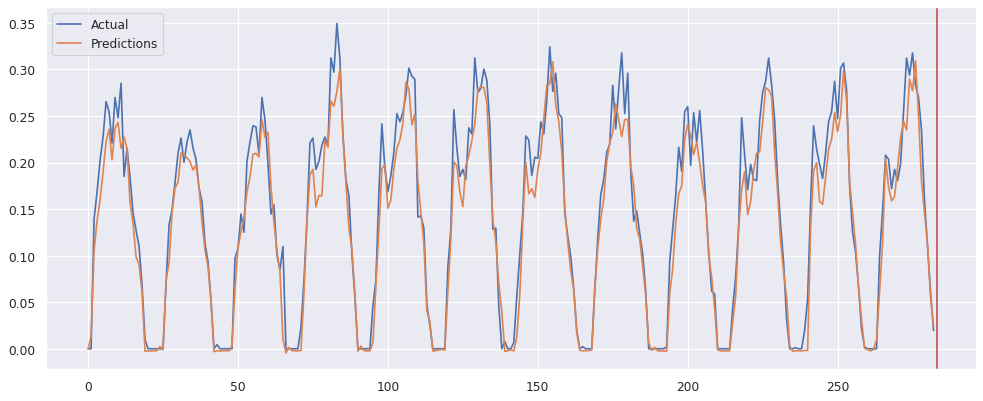

In [78]:
def plot_result(actual, predictions):
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(actual), color='r')
    plt.legend(['Actual', 'Predictions'])
    #plt.xlabel('Observation number after given time steps')
    #plt.ylabel('Sunspots scaled')
    #plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(testY[139], test_predict[139])

In [79]:
temp = [a_i - b_i for a_i, b_i in zip(testY[139], test_predict[139])]

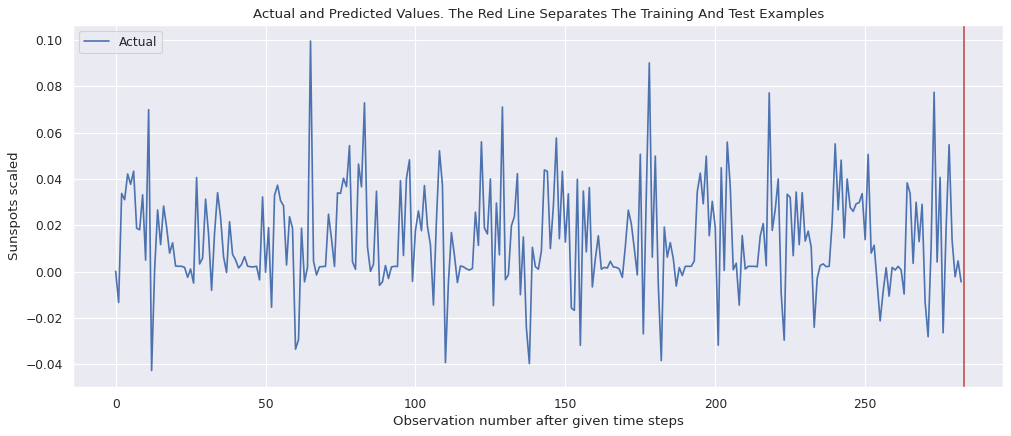

In [80]:
plot_one(temp)

In [81]:
temp2 = [item for sublist in temp for item in sublist]

<AxesSubplot:ylabel='Count'>

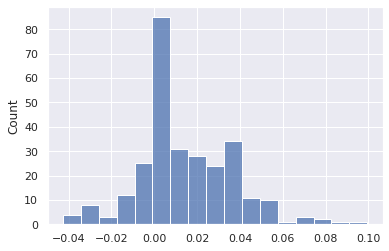

In [82]:
seaborn.set()
seaborn.histplot(temp2)

In [94]:
result = 0
amount = 0
for i in range(len(testX)):
    results = model.evaluate(testX[i], testY[i], batch_size=128)
    result += results
    amount += 1
loss_value = result/amount
print("Overall loss: " + str(loss_value))
steps_MAE = loss_value * max_intersection_value
print("12 steps MAE: " + str(steps_MAE))

3/3 [==============================] - 0s 6ms/step - loss: 0.0208
Overall loss: 0.025612117049165967
12 steps MAE: 23.53753556818352


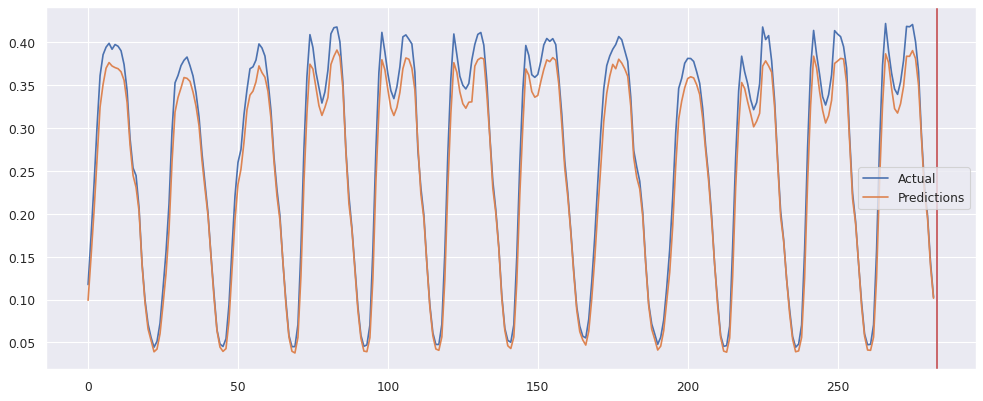

In [96]:
testY_avg = [0 for i in range(len(testY[0]))]
test_predict_avg = [0 for i in range(len(test_predict[0]))]

for i in range(len(testY)):
    for j in range(len(testY[i])):
        testY_avg[j] += testY[i][j]
        test_predict_avg[j] += test_predict[i][j]

amount = len(testY[0])

for i in range(len(testY_avg)):
    testY_avg[i] = testY_avg[i] / amount
    test_predict_avg[i] = test_predict_avg[i] / amount

plot_result(testY_avg, test_predict_avg)

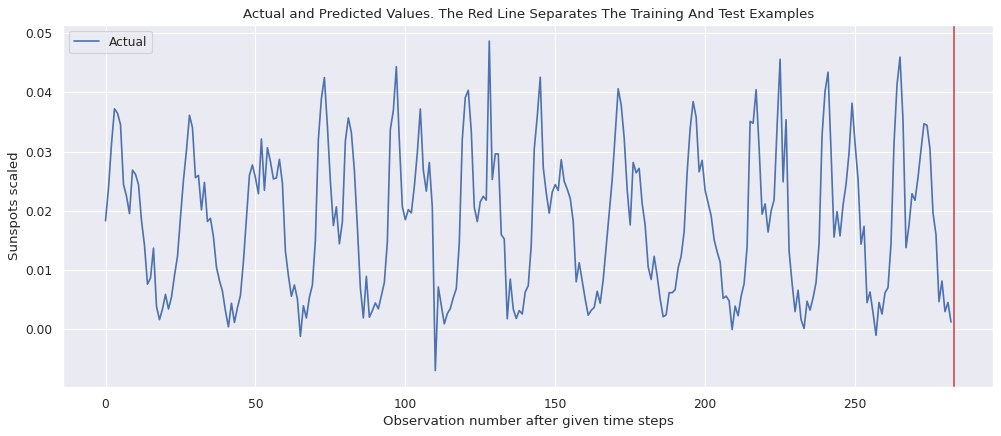

In [97]:
temp = [a_i - b_i for a_i, b_i in zip(testY_avg, test_predict_avg)]
plot_one(temp)

<AxesSubplot:ylabel='Count'>

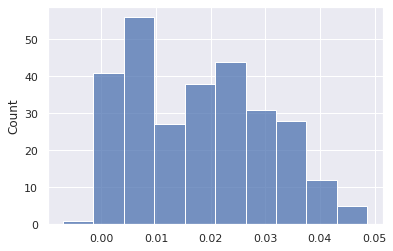

In [98]:
temp2 = [item for sublist in temp for item in sublist]
seaborn.set()
seaborn.histplot(temp2)